In [1]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points
import matplotlib.pyplot as plt

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 20/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         28.1696         3.57032   21.9733   36.1131
     Beta         1.86308         0.32449   1.32428   2.62111 

Goodness of fit    Value
 Log-likelihood -79.5482
           AICc  163.802
            BIC  165.088
             AD  0.83728 



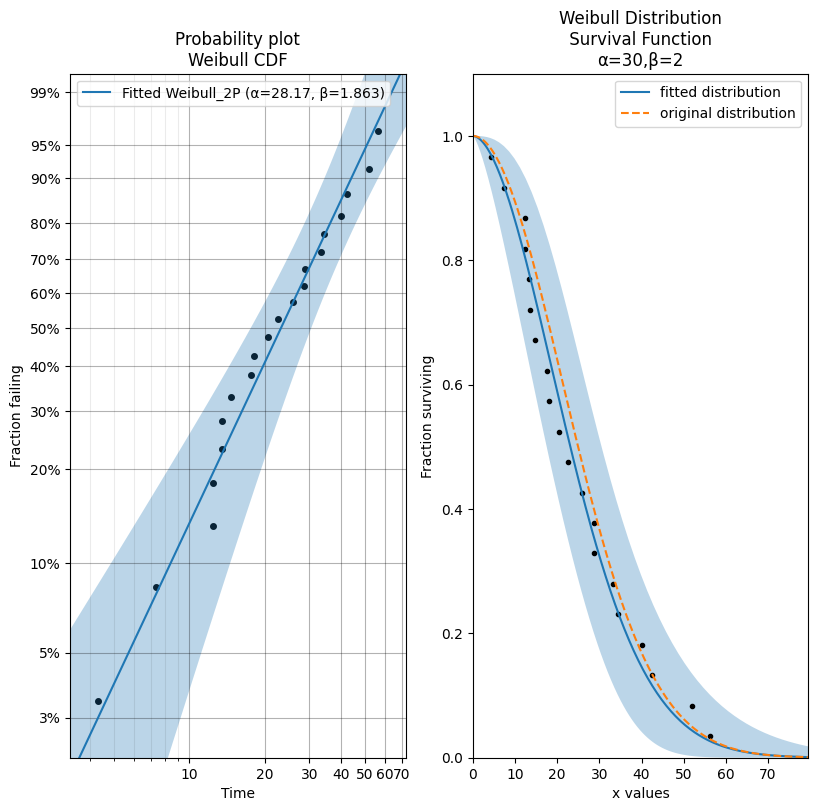

In [2]:
dist = Weibull_Distribution(alpha=30, beta=2)  # creates the distribution object
data = dist.random_samples(20, seed=42)  # draws 20 samples from the distribution. Seeded for repeatability
plt.subplot(121)
fit = Fit_Weibull_2P(failures=data)  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
dist.SF(label='original distribution', linestyle='--') # plots the survival function of the original distribution
plot_points(failures=data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()